In [8]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Aperiodic Models and sample fitting

In [9]:
def linear_model(x, b, c):
    # b: slope, c: intercpet
    # the parameters are named so that they are consistent with the quadratic model
    return b * x + c


def linear_model_log_prior(theta):
    return 0.0  # no prior restirction for now


def linear_model_log_likelihood(theta, x, y, yerr):
    model = linear_model(x, *theta)
    return -0.5 * np.sum((y - model) ** 2 / (yerr**2))


def linear_model_log_probability(theta, x, y, yerr):

    # check that the priors are satisfied
    lp = linear_model_log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + linear_model_log_likelihood(theta, x, y, yerr)


def quadratic_model(x, a, b, c):
    # a: quadratic coefficient , b: linear coefficent, c: constant coefficient
    return a * x * x + b * x + c

In [ ]:
# helper functions for plotting, model selection

import inspect

import numpy as np
from astropy.stats import median_absolute_deviation

def rmse(model, actual):
    return np.sqrt(np.sum(np.square(np.abs(model - actual))) / len(actual))


# Adapted from https://www.arxiv.org/abs/2511.16504 (TTV analysis, section 3.3), the following model evaluation criteria are implemented
# - Bayesian Information Criterion (BIC). Use Delta BIC to compare 2 models. (the smaller the better)
#   - if bic_delta is large, e.g., > 10 in the paper, it means the quad model is preferred over the linear one
# - Scatter statistics, to ensure the signals have a significant amplitude relative to the measurement uncertainties.
#   - in the paper, the statistics > 3 is considered strong / highly significant; [2, 3] is considered moderate.

def calculate_weighted_bic(y_true, y_pred, sigmas, n_params):
    # the log-likelihood is for independent Gaussian errors with known variances

    # n_params: num. of params in the model. Quadratic: 3, linear: 2

    n = len(y_true)
    # Weighted sum of squares
    weighted_rss = np.sum(((y_true - y_pred) / sigmas)**2)
    # Log-likelihood for known heteroscedastic errors
    log_likelihood = -0.5 * (np.sum(np.log(2 * np.pi * sigmas**2)) + weighted_rss)

    bic = -2 * log_likelihood + n_params * np.log(n)
    return bic


def calculate_scatter_statistics(y, sigmas):
    # in the context of O-C,
    # - y is the O-C,
    # - sigmas is O-C error (of the individual measurements)
    return median_absolute_deviation(y) / np.median(sigmas)


def get_model_param_names(model_func):
    # skip the first parameter, which is x:
    return list(inspect.signature(model_func).parameters.keys())[1:]

### Synthetic data

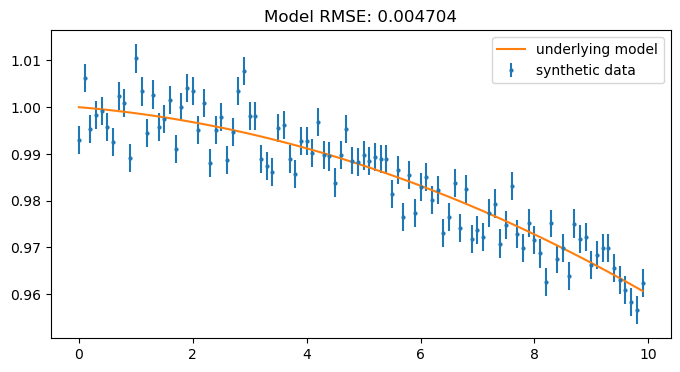

In [11]:
rng = np.random.default_rng(12345)

time = np.arange(0, 10, 0.1)
# model_flux_pure = linear_model(time, -0.005, 1)
model_flux_pure = quadratic_model(time, -0.0003, -0.001, 1)
flux = model_flux_pure + rng.normal(loc=0, scale=0.005, size=len(time))  # add some random noise
flux_err = rng.normal(loc=0.003, scale=0.00001, size=len(time))

ax = plt.figure(figsize=(8, 4)).gca();
ax.errorbar(time, flux, yerr=flux_err, linestyle="none", fmt="o", markersize=2, label="synthetic data");
ax.plot(time, model_flux_pure, label="underlying model");
ax.set_title(f"Model RMSE: {rmse(model_flux_pure, flux):.6f}");
ax.legend();
# ^^^ the base RMSE reflecting the nature of the data noises



### Find best-fit linear model with `scipy` `curve_fit()`

b: -0.004038229533890997 +- 0.00010396055652636963
c: 1.0050517381591209 +- 0.0005956109228424136


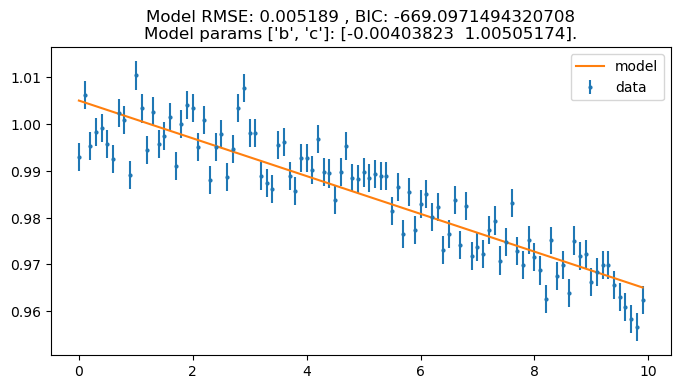

In [49]:
from scipy.optimize import curve_fit

# 3. Use curve_fit to find optimal parameters
# popt contains the optimal parameters (a, b)
# pcov contains the estimated covariance of popt
popt, pcov = curve_fit(
    linear_model, time, flux, sigma=flux_err, absolute_sigma=True,
    p0=(0, 1),  # initial guess
    nan_policy="omit",
)
perr = np.sqrt(np.diag(pcov))  # convert covaraince matrix to uncertaintiy in standard error
for _n, _v, _e in zip(get_model_param_names(linear_model), popt, perr):
    print(f"{_n}: {_v} +- {_e}")


model_flux = linear_model(time, *popt)


ax = plt.figure(figsize=(8, 4)).gca();
ax.errorbar(time, flux, yerr=flux_err, linestyle="none", fmt="o", markersize=2, label="data");
ax.plot(time, model_flux, label="model");
ax.set_title(f"""\
Model RMSE: {rmse(model_flux, flux):.6f} , BIC: {calculate_weighted_bic(flux, model_flux, flux_err, len(popt))}
Model params {get_model_param_names(linear_model)}: {popt}.""")
ax.legend();


### Find best-fit quadratic model with `scipy` `curve_fit()`

a: -0.0002966518863999975 +- 4.024072082053098e-05
b: -0.0011014819054171376 +- 0.00041171037967151935
c: 1.0002543625946785 +- 0.0008821811057641771


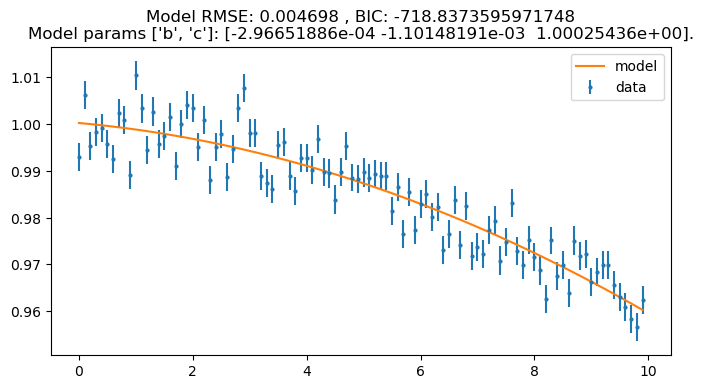

In [47]:
from scipy.optimize import curve_fit

# 3. Use curve_fit to find optimal parameters
# popt contains the optimal parameters (a, b)
# pcov contains the estimated covariance of popt
popt, pcov = curve_fit(
    quadratic_model, time, flux, sigma=flux_err, absolute_sigma=True,
    p0=(0, 0, 1),  # initial guess
    nan_policy="omit",
)
perr = np.sqrt(np.diag(pcov))  # convert covaraince matrix to uncertaintiy in standard error
for _n, _v, _e in zip(get_model_param_names(quadratic_model), popt, perr):
    print(f"{_n}: {_v} +- {_e}")

model_flux = quadratic_model(time, *popt)


ax = plt.figure(figsize=(8, 4)).gca();
ax.errorbar(time, flux, yerr=flux_err, linestyle="none", fmt="o", markersize=2, label="data");
ax.plot(time, model_flux, label="model");
ax.set_title(f"""\
Model RMSE: {rmse(model_flux, flux):.6f} , BIC: {calculate_weighted_bic(flux, model_flux, flux_err, len(popt))}
Model params {get_model_param_names(linear_model)}: {popt}.""")
ax.legend();


### Check if using BIC is appropriate

TODO: determine if BIC is an appropriate choice for the problem
- check if sample size is too large or too small. 
  - if ln(n) >> ~2 - 3, the penalty (for models with more params) might be too harsh, at least much harsher than AIC
    - AIC's weight factor is 2, which is about n = 7.4
  - if n is small (e.g., < 30), the log likelihood estimate is probably unstable too.
- BiC assumes the error is Gaussian.
  - can probably test how well the error fits Gaussian, or use statmodels' `acorr_ljungbox` to ee if there is any time-related correlation.
- Consider alternatives: AIC, AICc, RMSE, adjusted R squared, etc.


### Find best-fits using `statsmodels` WLS - variant formula

- WLS: Weighted Least Square: a variant of ordinary least square that takes into account for uncertainty in `y`
- the formulas are R-style formulas with some extensions, e.g., support `np` functions (or any vectorized functions)
    - internally, it uses `patsy` package to convert a formula into a design matrix.
    - https://www.statsmodels.org/stable/example_formulas.html

- `statsmodels` limitation: the family of methods available are all linear regressions, i.e., the model must be linear.
    - E.g., it cannot be used to fit a general sinusoidal model as it is non-linear.
    - `curve_fit()` from `scipy` is needed instead.

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.864
Model:                            WLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     309.0
Date:                Thu, 25 Dec 2025   Prob (F-statistic):           8.42e-43
Time:                        11:45:11   Log-Likelihood:                 394.13
No. Observations:                 100   AIC:                            -782.3
Df Residuals:                      97   BIC:                            -774.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.0003      0.001    712.

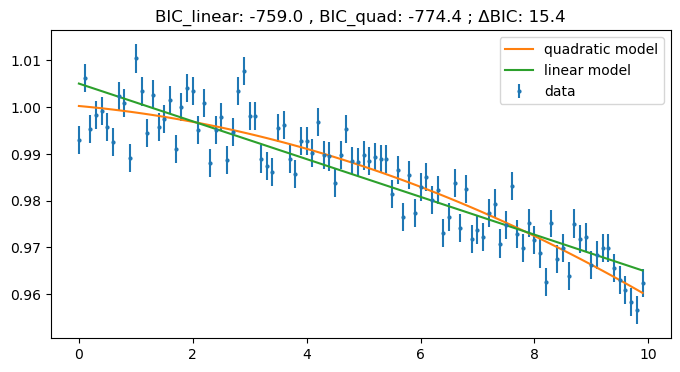

In [ ]:
import statsmodels.formula.api as smf

def fit_quadratic_model(time, flux, flux_err):
    x, y, errors = time, flux, flux_err

    # Define weights as 1/sigma^2
    weights = 1.0 / (errors**2)

    # Fit Weighted Least Squares
    # the formula automatically includes an intercept (beta0)
    wls_model = smf.wls(formula="y ~ x + np.power(x, 2)", data=dict(x=x, y=y), weights=weights).fit()

    return wls_model


def fit_linear_model(time, flux, flux_err):
    x, y, errors = time, flux, flux_err

    # Define weights as 1/sigma^2
    weights = 1.0 / (errors**2)

    # Fit Weighted Least Squares
    # the formula automatically includes an intercept (beta0)
    wls_model = smf.wls(formula="y ~ x", data=dict(x=x, y=y), weights=weights).fit()

    return wls_model


model_quad = fit_quadratic_model(time, flux, flux_err)
print(model_quad.summary())
print(model_quad.params)  # the coefficients

print("\n------\n")

model_linear = fit_linear_model(time, flux, flux_err)
print(model_linear.summary())
print(model_linear.params)  # the coefficients


print("\n------\n")

# if bic_delta is large, e.g., > 10, it means the quad model is preferred over the linear one
# the arbitrary threshold of 10 is adapted from https://www.arxiv.org/abs/2511.16504 (TTV analysis)
bic_delta = model_linear.bic - model_quad.bic
quad_preferred = bic_delta > 10
print(f"ΔBIC: {bic_delta} ; Is quadratic preferred? {quad_preferred}")

#
# Plot the data along with the model
#
ax = plt.figure(figsize=(8, 4)).gca();
ax.errorbar(time, flux, yerr=flux_err, linestyle="none", fmt="o", markersize=2, label="data");

model_time = np.linspace(time[0], time[-1], num=100)
quad_flux = model_quad.predict(exog={'x': model_time})
ax.plot(model_time, quad_flux, label="quadratic model");

linear_flux = model_linear.predict(exog={'x': model_time})
ax.plot(model_time, linear_flux, label="linear model");

ax.set_title(f"BIC_linear: {model_linear.bic:.1f} , BIC_quad: {model_quad.bic:.1f} ; ΔBIC: {bic_delta:.1f}")
ax.legend();

# Residuals of the fitted data
# model_quad.resid

# Weighted residuals of the fitted data, adjusted by square root of the weight
# model_quad.wresid

### Find best-fits using `statsmodels` WLS - variant design matrix

- lower-level / harder to use by explicitly specifying the design matrix representing the formula

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.864
Model:                            WLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     309.0
Date:                Thu, 25 Dec 2025   Prob (F-statistic):           8.42e-43
Time:                        11:49:45   Log-Likelihood:                 394.13
No. Observations:                 100   AIC:                            -782.3
Df Residuals:                      97   BIC:                            -774.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0003      0.001    712.905      0.0

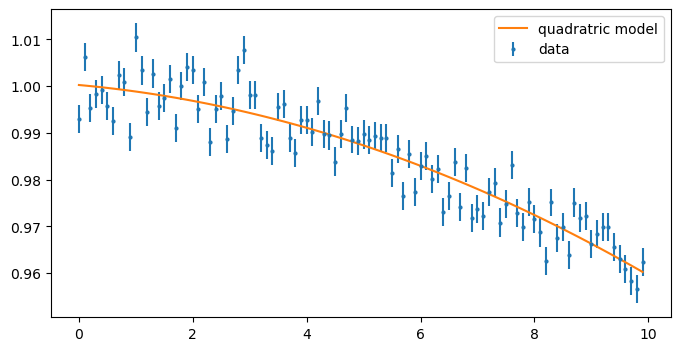

In [43]:
# Implement the models using statsmodels with design matrix for Weighted Least Squares (WLS), which account for flux_err

import statsmodels.api as sm

def fit_quadratic_model(time, flux, flux_err):
    x, y, errors = time, flux, flux_err

    # Prepare quadratic features: [1, x, x^2]
    X = np.column_stack((np.ones(len(x)), x, x**2))

    # Define weights as 1/sigma^2
    weights = 1.0 / (errors**2)

    # Fit Weighted Least Squares
    wls_model = sm.WLS(y, X, weights=weights).fit()
    return wls_model


def fit_linear_model(time, flux, flux_err):
    x, y, errors = time, flux, flux_err

    # Prepare linear features: [1, x]
    X = np.column_stack((np.ones(len(x)), x))

    # Define weights as 1/sigma^2
    weights = 1.0 / (errors**2)

    # Fit Weighted Least Squares
    wls_model = sm.WLS(y, X, weights=weights).fit()
    return wls_model


model_quad = fit_quadratic_model(time, flux, flux_err)
print(model_quad.summary())
print(model_quad.params)  # the coefficients

print("\n------\n")

model_linear = fit_linear_model(time, flux, flux_err)
print(model_linear.summary())
print(model_linear.params)  # the coefficients


print("\n------\n")

# if bic_delta is large, e.g., > 10, it means the quad model is preferred over the linear one
# the arbitrary threshold of 10 is adapted from https://www.arxiv.org/abs/2511.16504 (TTV analysis)
bic_delta = model_linear.bic - model_quad.bic
quad_preferred = bic_delta > 10
print(f"ΔBIC: {bic_delta} , Quadratic preferred? {quad_preferred}")

#
# Plot the data along with the model
#
ax = plt.figure(figsize=(8, 4)).gca();
ax.errorbar(time, flux, yerr=flux_err, linestyle="none", fmt="o", markersize=2, label="data");

def get_quad_design_matrix_for_new_x(new_x):
    # Transform into the design matrix format: [1, x, x^2]
    # Use sm.add_constant to include the intercept (column of ones)
    new_X_matrix = np.column_stack((new_x, new_x**2))
    new_X_matrix = sm.add_constant(new_X_matrix)
    return new_X_matrix

model_time = np.linspace(time[0], time[-1], num=100)
quad_flux = model_quad.predict(get_quad_design_matrix_for_new_x(model_time))
ax.plot(model_time, model_flux, label="quadratric model");
ax.legend();


array([ 1.00025436e+00, -1.10148190e-03, -2.96651887e-04])

In [14]:
import statsmodels.api as sm

# Sample data: y = b0 + b1*x + b2*x^2
x = np.array([1, 2, 3, 4, 5])
y = np.array([2.1, 3.9, 10.2, 16.5, 26.1])
errors = np.array([0.1, 0.2, 0.5, 0.3, 0.4]) # Standard deviations (sigma)

# Prepare quadratic features: [1, x, x^2]
X = np.column_stack((np.ones(len(x)), x, x**2))
print(X)


# Define weights as 1/sigma^2
weights = 1.0 / (errors**2)

# Fit Weighted Least Squares
wls_model = sm.WLS(y, X, weights=weights).fit()

# The .bic property automatically uses the weighted log-likelihood
print(wls_model.summary())
print(f"Weighted BIC: {wls_model.bic}")

[[ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]
 [ 1.  4. 16.]
 [ 1.  5. 25.]]
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.998
Model:                            WLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     567.9
Date:                Thu, 25 Dec 2025   Prob (F-statistic):            0.00176
Time:                        10:58:36   Log-Likelihood:                -1.8880
No. Observations:                   5   AIC:                             9.776
Df Residuals:                       2   BIC:                             8.604
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

c:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus2\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [7]:
import etv_functions

etv_functions.run_mcmc_initial_fit_of_model(linear_model_log_probability, linear_model, )

TypeError: run_mcmc_initial_fit_of_model() missing 2 required positional arguments: 'data' and 'start_vals_dict'